# Step 2 : build a Runge-Kutta type time-stepper

📜 _Once obtained the following_ $Q$_-coefficients :_

$$
\begin{array}
    {c|c}
    \tau & Q \\
    \hline
    & w^\top
\end{array}
$$

_we can use those to build the associated time-stepping scheme and solve time-dependent problems._

> 📣 Remember, this is exactly the same as Butcher tables for a Runge-Kutta method ...

Consider the following simple ODE, usually named _Dahlquist problem_ :

$$
\frac{du}{dt} = \lambda u, \quad t \in [0, T], \quad u(0)=u_0.
$$

We choose here $\lambda=i$ (imaginary unit), $T=4\pi$, and $u_0=e^{\frac{i\pi}{6}}$ :

In [1]:
import numpy as np

lam = 1j
T = 4*np.pi
u0 = np.exp(1j*np.pi/6)

Let say we want to solve it numerically, using $12$ time-steps of the famous RK4 method. This is how we do it with `qmat` :

In [2]:
from qmat import Q_GENERATORS

rk = Q_GENERATORS["RK4"]()
nodes, weights, Q = rk.genCoeffs()

nSteps = 12
uNum = np.zeros(nSteps+1, dtype=complex)
uNum[0] = u0

dt = T/nSteps
A = np.eye(nodes.size) - lam*dt*Q  # all-at-once system

for i in range(nSteps):
    b = np.ones(nodes.size)*uNum[i]  # ... with its RHS
    uNodes = np.linalg.solve(A, b)   # ... and its solution
    uNum[i+1] = uNum[i] + lam*dt*weights.dot(uNodes)  # prolongation


To explain a bit, we simply computed $N=12$ time-step solutions $u_1:=u(t_1), \dots, u_n:=u(t_n) \dots, u_{N}:=u(t_N)=u(T)$,
with $t_{n+1}-t_{n} = \Delta{t} = T/N$. One time-step consists on :

1. solving the **all-at-once system** :

$$
(I - \lambda\Delta{t} Q) u_\tau = [u_n, \dots, u_n]^T,
$$

where $u_\tau$ stores the numerical approximation at $t_n + \Delta{t}\tau_m$, also called the **nodes solution** (for collocation methods) or **stage solutions** (for RK methods).

2. updating the step solution with the **prolongation** :

$$
u_{n+1} = u_{n} + \lambda\Delta{t} w^T u_\tau
$$

... and that's it

> 💡 The code is independent from the fact that we used the RK4 scheme, or whatever else ... 

We show the time solution below, starting from the initial solution (orange square), and with the exact analytic solution in dashed line :

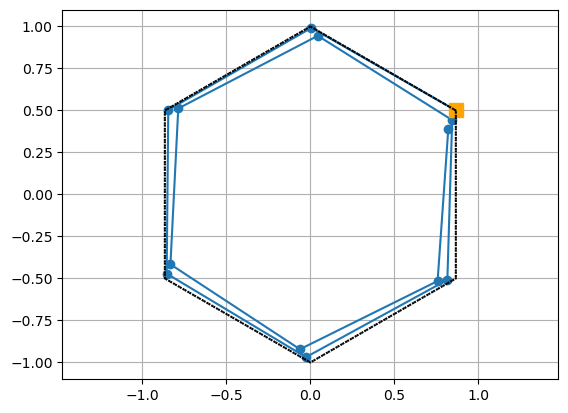

In [3]:
import matplotlib.pyplot as plt
plt.plot(uNum.real, uNum.imag, 'o-')
plt.axis("equal")

times = np.linspace(0, T, nSteps+1)
uExact = u0 * np.exp(lam*times)
plt.plot(uExact[0].real, uExact[0].imag, 's', ms=10, c="orange")
plt.plot(uExact.real, uExact.imag, ':', c="k")
plt.grid()


As expected, we can observe some numerical error of the time-scheme, since we do not retrieve exactly the hexagon showed by the exact solution.
One accuracy indicator is the $L_\infty$ error in time (computed over all time-steps) :

In [4]:
print("L_inf error : {:1.5f}".format(np.linalg.norm(uNum-uExact, ord=np.inf)))

L_inf error : 0.11925


Now let say we want to use a collocation method instead of RK4, using $4$ Legendre Radau-II nodes (_i.e_ Radau nodes including the right time interval bound). The only line we have to change in the previous code is :

In [5]:
# replace : "rk = Q_GENERATORS["RK4"]()" by 
coll = Q_GENERATORS["coll"](nNodes=4, nodeType="LEGENDRE", quadType="RADAU-RIGHT")

Then the **exact same code as before** can be used to build the time-stepper, compute the numerical solution and the error. In practice, you don't have to, as the $Q$-generators in `qmat` already provides dedicated methods for that :

L_inf error : 0.00001


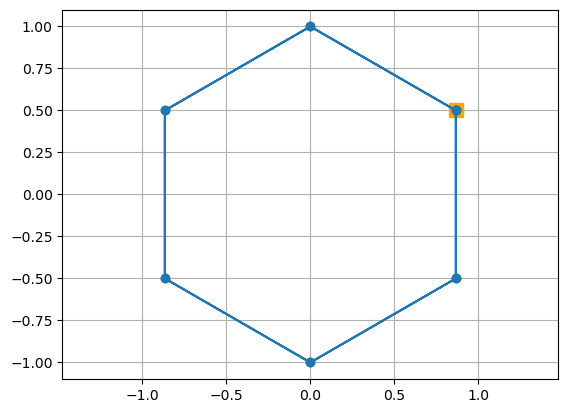

In [6]:
uNum = coll.solveDahlquist(lam, u0, T, nSteps)
plt.plot(uNum[0].real, uNum[0].imag, 's', ms=10, c="orange")
plt.plot(uNum.real, uNum.imag, 'o-')
plt.axis("equal")
plt.grid()
print("L_inf error : {:1.5f}".format(coll.errorDahlquist(lam, u0, T, nSteps, uNum=uNum)))

Now the error is way lower, even if we used $Q$-coefficients of the same size ... but there is a major difference here between the two $Q$ matrices :

In [7]:
print("Q for RK4 :")
print(rk.Q)

print("Q for Collocation :")
print(coll.Q)

Q for RK4 :
[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]]
Q for Collocation :
[[ 0.11299948 -0.04030922  0.02580238 -0.00990468]
 [ 0.234384    0.20689257 -0.04785713  0.01604742]
 [ 0.21668178  0.40612326  0.18903652 -0.0241821 ]
 [ 0.22046221  0.38819347  0.32884432  0.0625    ]]


While $Q$ is **dense for the collocation method**, it is not (and actually lower triangular) for RK4. 
Hence in practice, solving the **all-at-once system** with the collocation method is the most expensive,
as we need to solve it ... well, _all-at-once_.

> 🔍 In this case (Dahlquist), solving the _all-at-once system_ it is easy and cheap as showed above. 
> But for large scale non-linear problems, this can quickly become unfeasible, as each time
> may represent thousands or millions of degrees of freedom ...

For RK4 though, solving the _all-at-once system_ is much simpler : one simply needs to solve the first node solution (explicit expression for RK4 since the diagonal coefficient is 0), then use it to solve the second node solution, etc ... 
so no need to solve the system all-at-once !
This is one reason why RK methods have been generally favored in scientific computing against collocation methods.

> 🔔 However, the high accuracy of collocation methods motivates to estimate the _all-at-once solution_ in a cheaper way than a direct solve, which is the main idea of **Spectral Deferred Correction (SDC)** and **Iterated Runge-Kutta methods**.
> Those use fixed-point preconditioned iterations to solve the all-at-once system, where the preconditoner is built using a **lower triangular** approximation of the $Q$ matrix, named the $Q_\Delta$ **matrix**.

The second main feature of `qmat` is then to [generate those approximations ...](./03_qDelta.ipynb)